In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
%matplotlib inline
sns.set_style('darkgrid')


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
!pip install boto3

In [4]:
import pandas as pd
import boto3
import io
import s3fs # for handling S3 file systems in a way similar to os
from keras.preprocessing.image import ImageDataGenerator

# Define your S3 bucket and folders
bucket_name = 'food-data-test'
meta_path = 's3://' + bucket_name + '/meta/' # replace 'meta' with your actual meta folder name
img_file_path = 's3://' + bucket_name + '/images/' # replace 'images' with your actual images folder name


In [5]:
# S3 resource setup
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

In [6]:
def load_csv_from_s3(filename):
    obj = s3.Object(bucket_name, 'meta/' + filename)
    return pd.read_csv(io.BytesIO(obj.get()['Body'].read()), names=['Food'])

In [7]:
# Loading meta files from S3
classes = load_csv_from_s3('classes.txt')
labels = load_csv_from_s3('labels.txt')
class_to_nominal = dict(zip(classes['Food'].values, range(classes.shape[0])))

### Code to get list of images file names

In [8]:
train_df_full=load_csv_from_s3('train.txt')
test_df_full=load_csv_from_s3('test.txt')

In [9]:
print(train_df_full)

                    Food
0      apple_pie/1005649
1      apple_pie/1014775
2      apple_pie/1026328
3      apple_pie/1028787
4      apple_pie/1043283
...                  ...
75745     waffles/981485
75746      waffles/98238
75747     waffles/982668
75748     waffles/995085
75749     waffles/999047

[75750 rows x 1 columns]


In [10]:
classes_needed = ['apple_pie',
'baby_back_ribs',
'caesar_salad',
'deviled_eggs',
'eggs_benedict',
'falafel',
'garlic_bread',
'hamburger',
'ice_cream',
'waffles']



In [11]:
def starts_with_any(word, word_list):
    return any(word.startswith(x) for x in word_list)

# Apply the function to the 'Food' column and filter the DataFrame
matched_rows = train_df_full['Food'].apply(lambda x: starts_with_any(x, classes_needed))

# Extract the 'Food' column values where condition is True
train_list = train_df_full['Food'][matched_rows].tolist()

# Apply the function to the 'Food' column and filter the DataFrame
matched_rows = test_df_full['Food'].apply(lambda x: starts_with_any(x, classes_needed))

# Extract the 'Food' column values where condition is True
test_list = test_df_full['Food'][matched_rows].tolist()

# Output the result
#print(train_list)

In [12]:
len(test_list)

2500

In [13]:
len(train_list)

7500

In [14]:
#train_df = pd.read_csv(META_PATH+'train.txt', names=['txt'], header=None)
train_df = pd.DataFrame(train_list, columns=['txt'])
train_df['img'] = train_df['txt'].apply(lambda x : x+'.jpg')
train_df['label'] = train_df['txt'].apply(lambda x: class_to_nominal[x.split('/')[0]])

train_df.drop(['txt'], axis=1, inplace=True)
train_df = train_df.sample(frac=1)

#valid_df = pd.read_csv(META_PATH+'test.txt', names=['txt'], header=None)
valid_df = pd.DataFrame(test_list, columns=['txt'])
valid_df['img'] = valid_df['txt'].apply(lambda x: x+'.jpg')
valid_df['label'] = valid_df['txt'].apply(lambda x: class_to_nominal[x.split('/')[0]])

valid_df.drop(['txt'], axis=1, inplace=True)
valid_df = valid_df.sample(frac=1)
         
print(f'train_data: {train_df.shape}')
print(f'valid_data: {valid_df.shape}')

train_data: (7500, 2)
valid_data: (2500, 2)


In [15]:
train_df.head()

,img,label
1563,caesar_salad/137024.jpg,2
5333,hamburger/1380338.jpg,7
7424,waffles/677805.jpg,9
6731,ice_cream/918181.jpg,8
4178,falafel/3116743.jpg,5


In [16]:
train_dg = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)

valid_dg = ImageDataGenerator(
        rescale=1./255,
)

In [17]:
print(train_df)

                            img  label
1563    caesar_salad/137024.jpg      2
5333      hamburger/1380338.jpg      7
7424         waffles/677805.jpg      9
6731       ice_cream/918181.jpg      8
4178        falafel/3116743.jpg      5
...                         ...    ...
4931   garlic_bread/3039541.jpg      6
3264  eggs_benedict/2248962.jpg      4
1653   caesar_salad/1791656.jpg      2
2607   deviled_eggs/2741731.jpg      3
2732   deviled_eggs/3318323.jpg      3

[7500 rows x 2 columns]


In [18]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
#S3_BUCKET = 's3://food-data-test'  # replace with your S3 bucket name
IMG_FILE_PATH = "images/"  # replace 'your-image-data-prefix' with the S3 prefix (folder) containing your images

# Assuming you've already loaded or defined train_df and valid_df DataFrames


train_data = train_dg.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_FILE_PATH,  # set to None because we'll use absolute paths in 'img' column
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
    validate_filenames=True  # add this parameter since files are not locally available
)

valid_data = valid_dg.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMG_FILE_PATH,  # set to None because we'll use absolute paths in 'img' column
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
    validate_filenames=True  # add this parameter since files are not locally available
)

Found 7500 validated image filenames.
Found 2500 validated image filenames.


In [19]:
print(train_data)

KeyError: 0

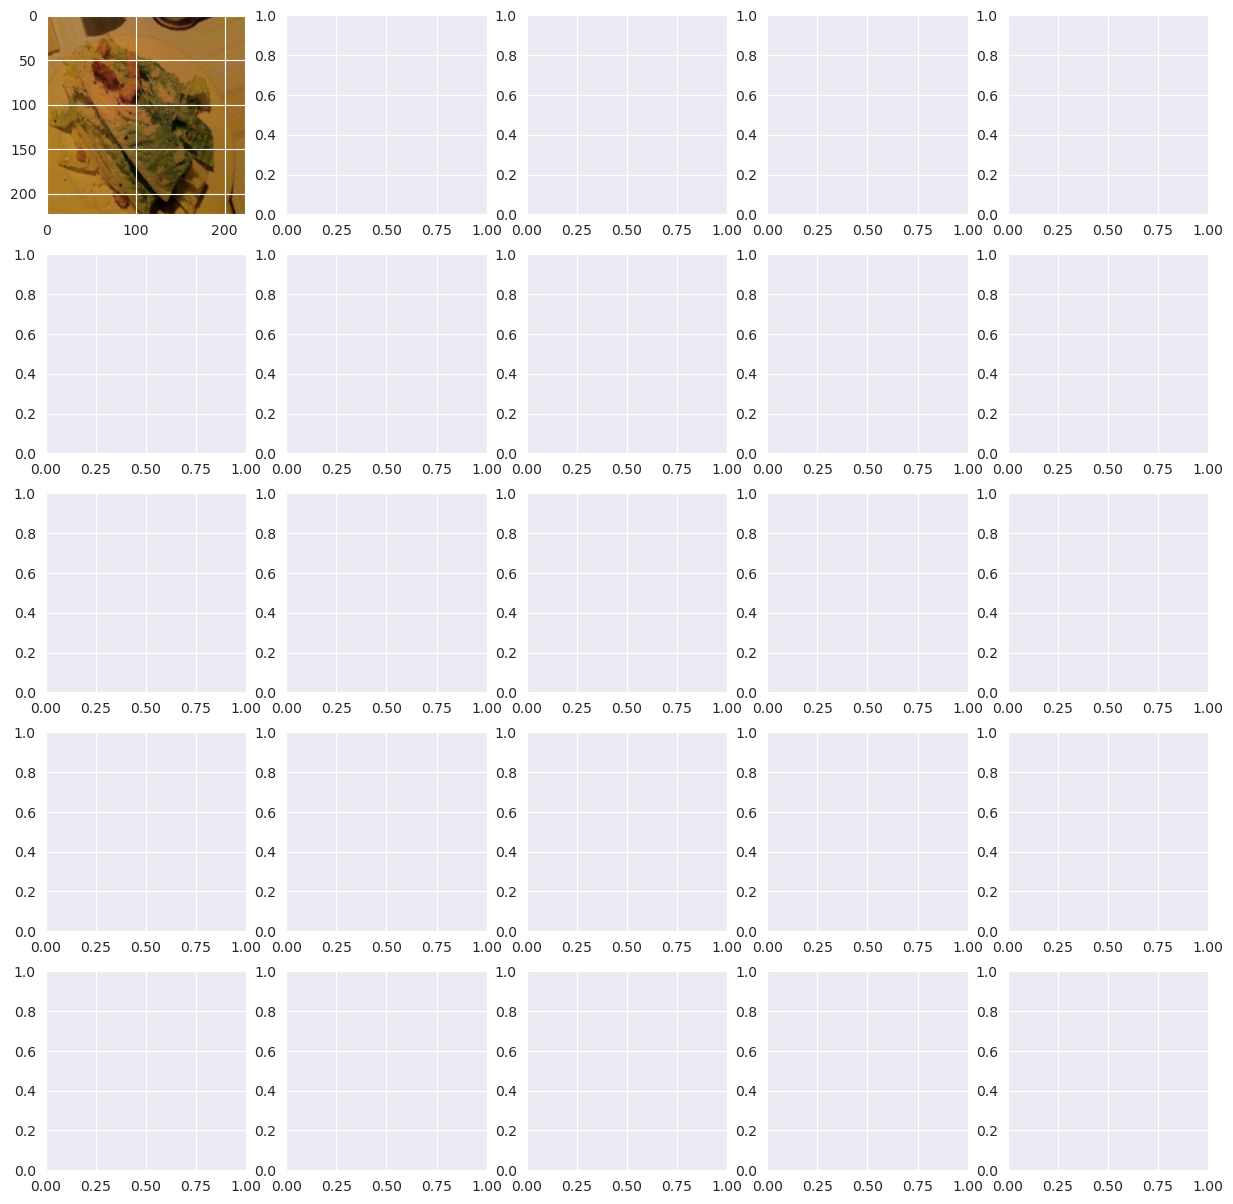

In [40]:
x, y = next(train_data)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x[i+j*5])
        ax[i][j].set_title(labels[0][y[i+j*5]])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
fig.show()

In [21]:
pre_trained = keras.applications.MobileNetV3Large(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
pre_trained.trainable = True

In [22]:
model = keras.Sequential([
    pre_trained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 101)               13029     
                                                                 
Total params: 3132389 (11.95 MB)
Trainable params: 31079

In [ ]:
EPOCHS=20

# callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
chkp = keras.callbacks.ModelCheckpoint('mobilenet_v3_large_checkpoint.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

with tf.device('/GPU:0'):
    hist = model.fit(
        train_data,
        validation_data = valid_data,
        epochs = EPOCHS,
        callbacks=[early_stop, reduce_lr, chkp],
    )

model.save('mobilenet_v3_large_final.h5')

Epoch 1/20
